In [ ]:
import numpy as np
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
                                transforms.Resize((64,64))])
train_dataset = CIFAR10(root='data', train=True, transform=transform, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


In [ ]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])
test_set = CIFAR10(root='data', train=False, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 3, 64, 64])


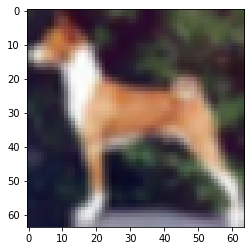

In [ ]:
for data, label in train_loader:
  print(data.shape)
  tensor_to_pil = transforms.ToPILImage()(data[2,:,:,:].squeeze_(0))
  plt.imshow(tensor_to_pil)
  break

In [ ]:
class VisualEncoder(nn.Module):
    def __init__(self, features_dim=512):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4, padding=0),  # (3, 64, 64) -> (32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0), #             -> (64, 5, 5)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0), #             -> (64, 3, 3)
            nn.ReLU(),
            nn.Flatten(),
        )

        n_flatten = 1024
        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, x):
        return self.linear(self.cnn(x))

class VisualDecoder(nn.Module):
    def __init__(self, features_dim=512):
        super().__init__()

        n_flatten = 1024
        self.linear = nn.Sequential(nn.Linear(features_dim, n_flatten), nn.ReLU())

        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3,stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=0,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 8,stride=4, padding=0),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], 64, 4, 4)
        x = self.cnn(x)
        return x 

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self,
               encoder_class : object = VisualEncoder,
               decoder_class : object = VisualDecoder):
    super().__init__()
    self.encoder = encoder_class()
    self.decoder = decoder_class()
  def forward(self, x):
    encode = self.encoder(x)
    decode = self.decoder(encode)
    return decode


In [ ]:
model = Autoencoder()

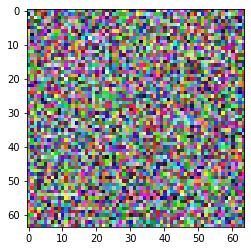

In [ ]:
test = torch.randn(1,3, 64,64)
resized = torch.reshape(test,[1,3,64,64])
tensor_to_pil = transforms.ToPILImage()(resized.squeeze_(0))
plt.imshow(tensor_to_pil)

In [ ]:
model(test).shape

torch.Size([1, 3, 64, 64])

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
epochs = 100
for epoch in range(epochs):
  for data,label in train_loader:
    predict = model(data)
    loss = criterion(predict, data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(loss)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor(0.0934, grad_fn=<MseLossBackward>)
tensor(0.0815, grad_fn=<MseLossBackward>)
tensor(0.0681, grad_fn=<MseLossBackward>)
tensor(0.0611, grad_fn=<MseLossBackward>)
tensor(0.0575, grad_fn=<MseLossBackward>)
tensor(0.0554, grad_fn=<MseLossBackward>)
tensor(0.0535, grad_fn=<MseLossBackward>)
tensor(0.0530, grad_fn=<MseLossBackward>)
tensor(0.0559, grad_fn=<MseLossBackward>)
tensor(0.0513, grad_fn=<MseLossBackward>)
tensor(0.0535, grad_fn=<MseLossBackward>)


KeyboardInterrupt: ignored

In [ ]:
for data, label in train_loader:
  print(data.shape)
  tensor_to_pil = transforms.ToPILImage()(data[2,:,:,:].squeeze_(0))
  predict = model(data)
  predict_to_pil = transforms.ToPILImage()(predict[2,:,:,:].squeeze_(0))
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 3, 64, 64])


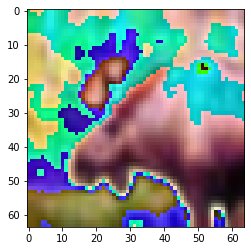

In [ ]:
plt.imshow(tensor_to_pil)

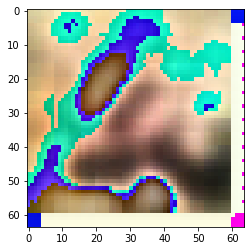

In [ ]:
plt.imshow(predict_to_pil)